<a href="https://colab.research.google.com/github/pauldebayan/SpectaGen/blob/main/SpectaGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import os
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
!wget https://github.com/pauldebayan/SpectaGen/raw/refs/heads/main/spectacle_dataset.zip
!unzip spectacle_dataset.zip

In [6]:
!ls

create_labels  process_images  spectacle_dataset      SpectaGen.ipynb
labels.csv     README.md       spectacle_dataset.zip


In [7]:
def ImagesToDelete():
    # To check all the images is of same shape
    channel, height, width = 3, 256, 512

    imagesToDelete = []

    for i in range(1000):
        img = read_image(f'./spectacle_dataset/specs{(i+1)}.jpg')

        if(img.shape[0] != 3 or img.shape[1] != 256 or img.shape[2] != 512):
            imagesToDelete.append(f'specs{(i+1)}.jpg')

    # We need to delete this images as they do not have the desired shape - [3, 256, 512]
    return imagesToDelete

print(ImagesToDelete())


[]


In [98]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 20, 2)
        self.conv2 = nn.Conv2d(20, 10, 2)
        self.conv3 = nn.Conv2d(10, 10, 2)

        self.activ = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.linear_stack = nn.Sequential(
            nn.Linear(19530, 2000),
            nn.LeakyReLU(),
            nn.Linear(2000,800),
            nn.LeakyReLU(),
            nn.Linear(800,400),
            nn.LeakyReLU(),
            nn.Linear(400, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.pool(self.activ(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)

        x = self.linear_stack(x)

        #return x.shape
        return x


In [103]:
class Genearator(nn.Module):

    def __init__(self):
        super().__init__()


        self.gen_sequence = nn.Sequential(
            nn.ConvTranspose2d(64, 512, 3, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(512, 256, 4, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, 4, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 3, 4, stride=2),
            nn.Tanh()
        )
        

    def forward(self, x):

        x = x.view(1, 64, 30, 62)
        #print(f'x.view(-1, 8, 8) shape: {x}')

        x = self.gen_sequence(x)
        return x


In [112]:
generator = Genearator()
discriminator = Discriminator()

print(discriminator)
print(generator)

Discriminator(
  (conv1): Conv2d(3, 20, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
  (activ): LeakyReLU(negative_slope=0.01)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_stack): Sequential(
    (0): Linear(in_features=19530, out_features=2000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2000, out_features=800, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=800, out_features=400, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=400, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Genearator(
  (gen_sequence): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

In [121]:
# To get the input of the linear layer in Discriminator

img = read_image('./spectacle_dataset/specs1.jpg')
print(img.shape)
# print(discriminator(img.float()))
# 19530

torch.Size([3, 256, 512])


In [122]:
def generateNoise():
    noise = torch.randn(1, 119040)
    return noise

# Conv2d: (N-K+1)/S
# ConvTranspose2d: (N-1)*S+K

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 512])
Fake image shape: torch.Size([1, 3, 256, 512])


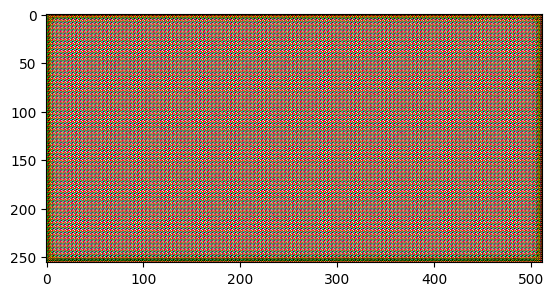

In [123]:
noise = generateNoise()
img = generator(noise)

print(img.shape)
plt.imshow(img.squeeze().detach().permute(1, 2, 0))

print(f"Fake image shape: {img.shape}")


In [124]:
# Real Images - set dataloader
class SpectDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [125]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Grayscale()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

dataset = SpectDataset(img_dir = 'spectacle_dataset', 
                             annotations_file = 'labels.csv', 
                             transform = transform)

batch_size = 5
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [126]:
epochs = 10000000
lr = 0.0001

In [127]:
loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [128]:
# Implementing GANs

for epoch in range(epochs):

    
    for real_img, real_label in dl:

        #Generator
        optimizer_G.zero_grad()
        noise = generateNoise()
        fake_img = generator(noise)
        fake_label = 0
        loss_G = loss_fn(discriminator(fake_img).squeeze(), torch.tensor(1).float())
        loss_G.backward()
        optimizer_G.step()


        #Discriminator
        optimizer_D.zero_grad()
        fake_loss = loss_fn(discriminator(fake_img.detach()).squeeze(), torch.tensor(0).float())
        real_loss = loss_fn(discriminator(real_img).mean().squeeze(), torch.tensor(1).float())
        loss_D = (fake_loss+real_loss)/2
        loss_D.backward()
        optimizer_D.step()

        gen_loss = loss_G.item()
        print(f"Epoch{epoch+1}: Discriminator Loss: {loss_D.item()}, Generator Loss: {gen_loss}")
        
        gen_loss = int(gen_loss)
        

    
    
    if epoch%10 == 0:
        noise = generateNoise()
        fake_img = generator(noise)
        torchvision.utils.save_image(fake_img, 'generated.jpg')
        plt.imshow(fake_img.squeeze().detach().permute(1, 2, 0))
        plt.show()
        torch.save(generator.state_dict(), 'model.pt')

    if gen_loss > 100:
        break


KeyboardInterrupt: 